In [1]:
import pandas as pd
import numpy as np

In [67]:
def format_stars(stars):
    stars = stars.split(', \'')
    stars = [star for star in stars if star != '' and star != '    Stars:\'']
    stars[0] = stars[0][2:]
    stars[-1] = stars[-1][:-2]

    dir_index = -1
    for j in range(len(stars)):
        stars[j] = stars[j].replace(', "', '')
        if 'Stars:\'' in stars[j]:
            stars[j] = stars[j].split(':\'')[1]
        
        if '|' in stars[j]:
            dir_index = j
    
    stars = stars[dir_index + 1:]

    return stars if stars != [] else None

def format_genres(genre):
    genres = genre.split(', ')
    return genres[0] if genres != [] else None

def format_years(year):
    if len(year) < 5 or year[1] not in ['1', '2']:
        return None
    return int(year[1:5])

def set_is_tv(duration):
    duration = int(duration[0: -4])

    if duration < 75:
        return True
    return False

def get_cleaned_dataframe():
    df = pd.read_csv('./n_movies.csv')
    df = df.drop(columns=['description', 'certificate'])
    df = df.dropna(subset=['stars', 'duration', 'year', 'genre'])
    df = df.drop_duplicates(subset=['title'])

    df['stars'] = df['stars'].apply(format_stars)
    df['genre'] = df['genre'].apply(format_genres)
    df['year'] = df['year'].apply(format_years)
    df['is_tv'] = df['duration'].apply(set_is_tv)

    df = df.dropna()
    df = df.reset_index()
    
    return df


In [74]:
df = get_cleaned_dataframe()

df_top = df.sort_values(by='votes', ascending=True)
actors = []
for index, row in df.iterrows():
    for star in row['stars']:
        if star not in actors:
            actors.append(star)
print(df_top.head())

      index                            title    year duration        genre  \
3207   3818                  The Real Miyagi  2015.0   80 min  Documentary   
4436   5430     Katt Williams: Great America  2018.0   60 min       Comedy   
2496   2925                     The Unlisted  2019.0   22 min       Family   
2383   2782  Saturday Morning All Star Hits!  2021.0   23 min    Animation   
5055   6312              The Mars Generation  2017.0   97 min  Documentary   

      rating                                              stars  votes  is_tv  
3207     7.1  [John G. Avildsen, Billy Blanks, Lauro David C...  1,001  False  
4436     6.2                        [    Star:', Katt Williams]  1,002   True  
2496     6.5  [Vrund Rao, Ved Rao, Abigail Adriano, Miah Mad...  1,005   True  
2383     7.5  [Kyle Mooney, Ben Jones, Eric Bauza, Geraldine...  1,005   True  
5055     6.5  [Elsa Shiju, Bob Behnken, Alayna Bidlack, Niko...  1,006  False  


In [4]:
conda install pyvis

Retrieving notices: ...working... done
Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [75]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyvis.network import Network

# Network Visualization of Media with shared actors
def create_media_network(df, network, num_nodes):

    # Creating Nodes
    for i in tqdm(range(num_nodes)):
        network.add_node(df.loc[i,'title'])

    # Creating Edges
    for i in tqdm(range(num_nodes)):
        for j in range(i + 1, num_nodes):
            w = 0
            for actor in df.loc[i, 'stars']:
                if actor in df.loc[j, 'stars']:
                    if w == 0:
                        w += 2
                    else:
                        w += 5
            if w > 0:
                network.add_edge(df.loc[i, 'title'], df.loc[j, 'title'], weight=w,)
    return network

movies = df.where(df['is_tv'] == False).dropna().reset_index(drop=True)
tv_shows = df.where(df['is_tv'] == True).dropna().reset_index(drop=True)
media = df.dropna().reset_index(drop=True)

# Creating the networks
movie_network = nx.MultiGraph()
tv_show_network = nx.MultiGraph()
combine_network = nx.MultiGraph()

movie_network = create_media_network(movies, movie_network, 200)
tv_show_network = create_media_network(tv_shows, tv_show_network, 200)
combine_network = create_media_network(media, combine_network, 200)

# Scaling the nodes based on their degree
scale=4
d_movie = dict(movie_network.degree)
d_movie.update((x, scale*y) for x, y in d_movie.items())
d_tv_show = dict(tv_show_network.degree)
d_tv_show.update((x, scale*y) for x, y in d_tv_show.items())
d_combine = dict(combine_network.degree)
d_combine.update((x, scale*y) for x, y in d_combine.items())

# Setting up size attribute
nx.set_node_attributes(movie_network, d_movie,'size')
nx.set_node_attributes(tv_show_network, d_tv_show,'size')
nx.set_node_attributes(combine_network, d_combine,'size')

# Creating the Pyvis Networks
nt_movie = Network("500px", "500px")
nt_tv_show = Network("800px", "800px")
nt_combine = Network("800px", "800px")

nt_movie.from_nx(movie_network)
nt_tv_show.from_nx(tv_show_network)
nt_combine.from_nx(combine_network)

nt_movie.show("nx_movie.html")
nt_tv_show.show("nx_tv_show.html")
nt_combine.show("nx_combine.html")

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 436.80it/s]


In [65]:
# Media Visualization of Actors with Shared Media

def create_actor_network(actors, df, network, num_nodes):
    # Creating Nodes
    for actor in range(num_nodes):
        network.add_node(actors[actor])

    # Creating Edges
    for i in range(num_nodes):
        for j in range(len(df)):
            if actors[i] in df.loc[j, 'stars']:
                for actor_2 in df.loc[j, 'stars']:
                    if (actor_2 != actors[i]) and (actor_2 in actors):
                        network.add_edge(actors[i], actor_2)

    return network

network = nx.MultiGraph()
network = create_actor_network(actors, df, network, 500)

# Scaling the nodes based on their degree
scale=4
d_actor = dict(network.degree)
d_actor.update((x, scale*y) for x, y in d_actor.items())

# Setting up size attribute
nx.set_node_attributes(network, d_actor,'size')

nt_actor = Network("500px", "500px")
nt_actor.from_nx(network)
nt_actor.show("nx_actor.html")

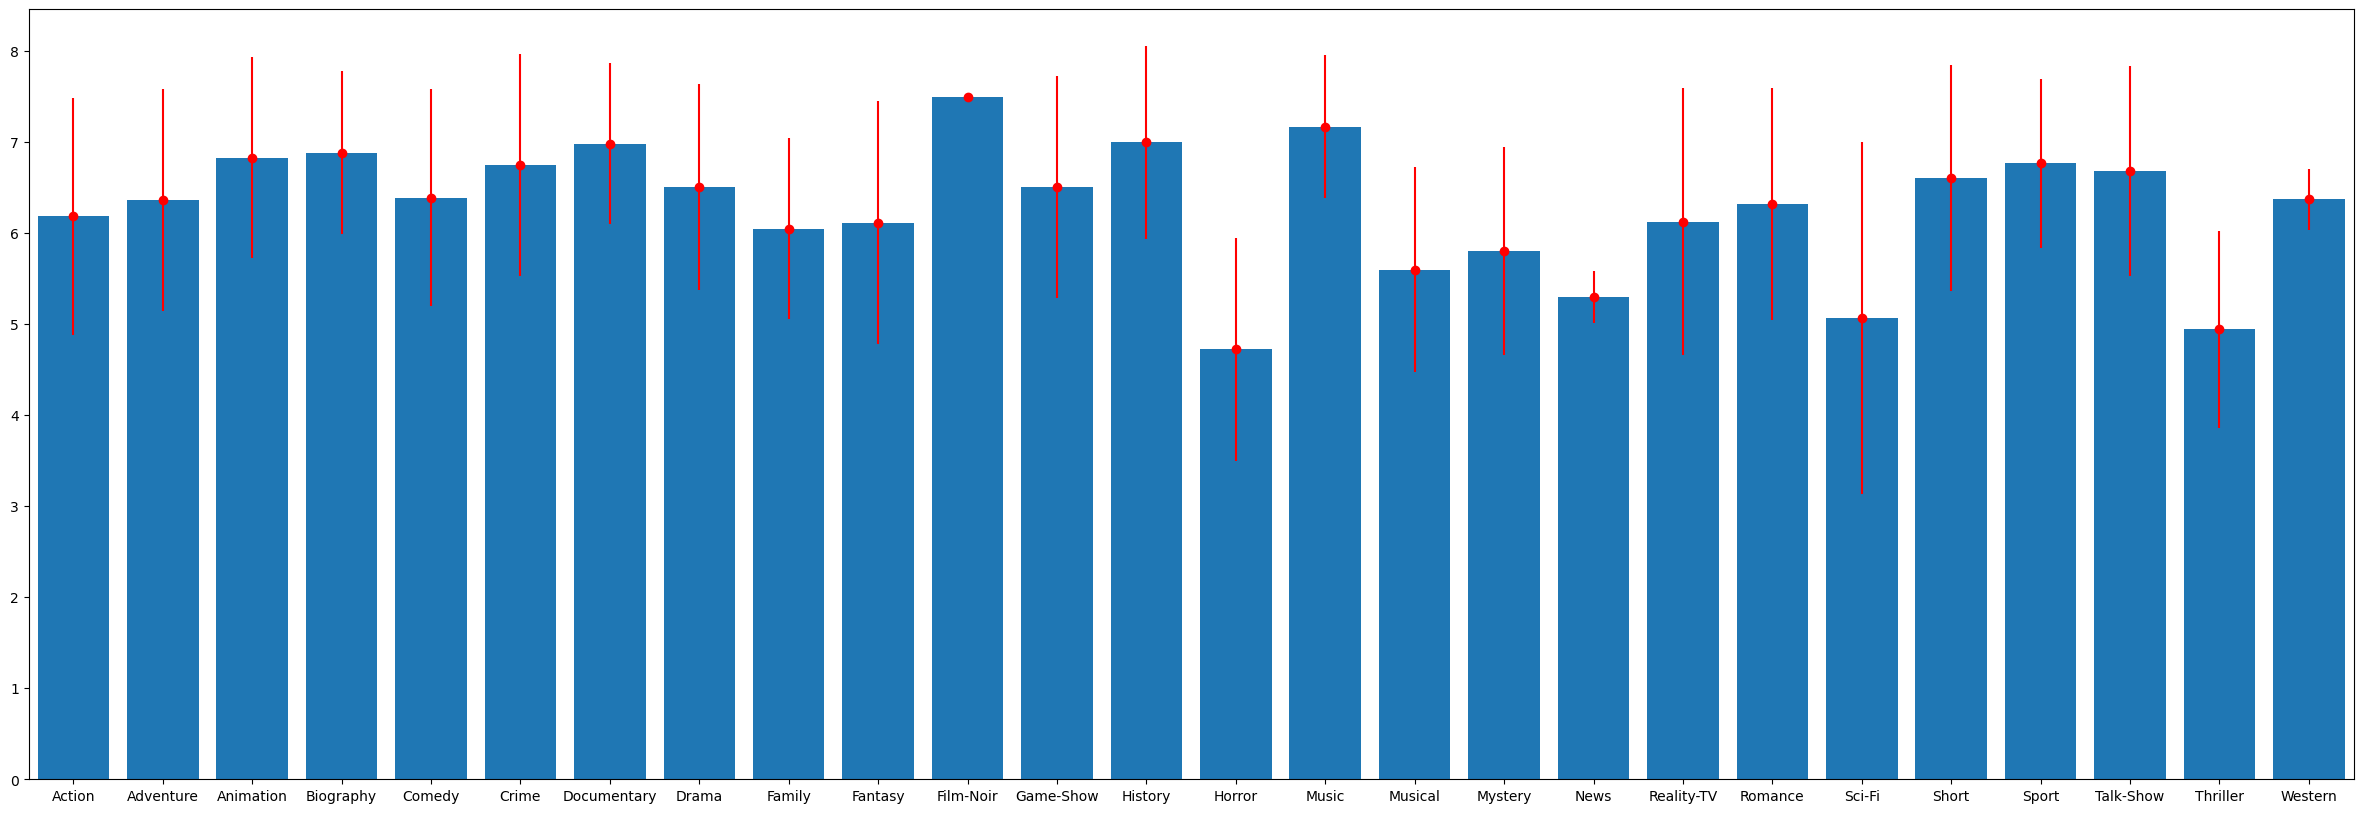

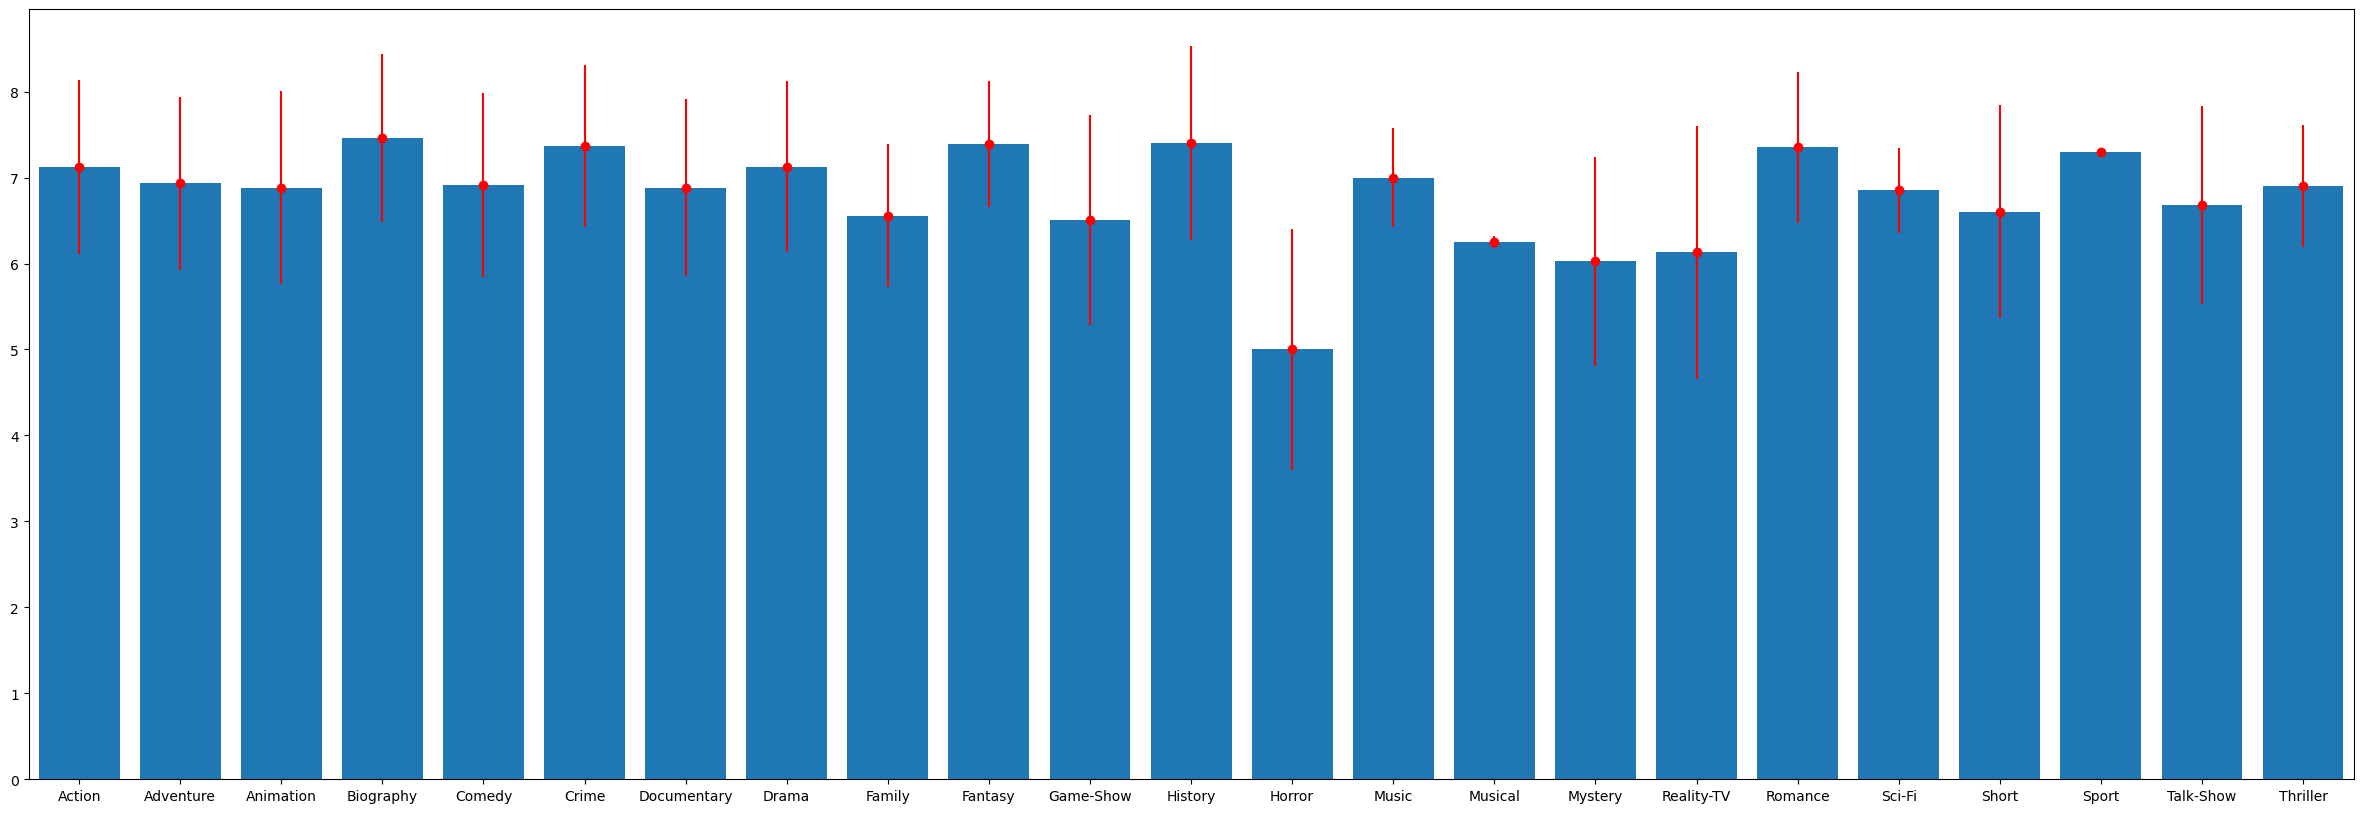

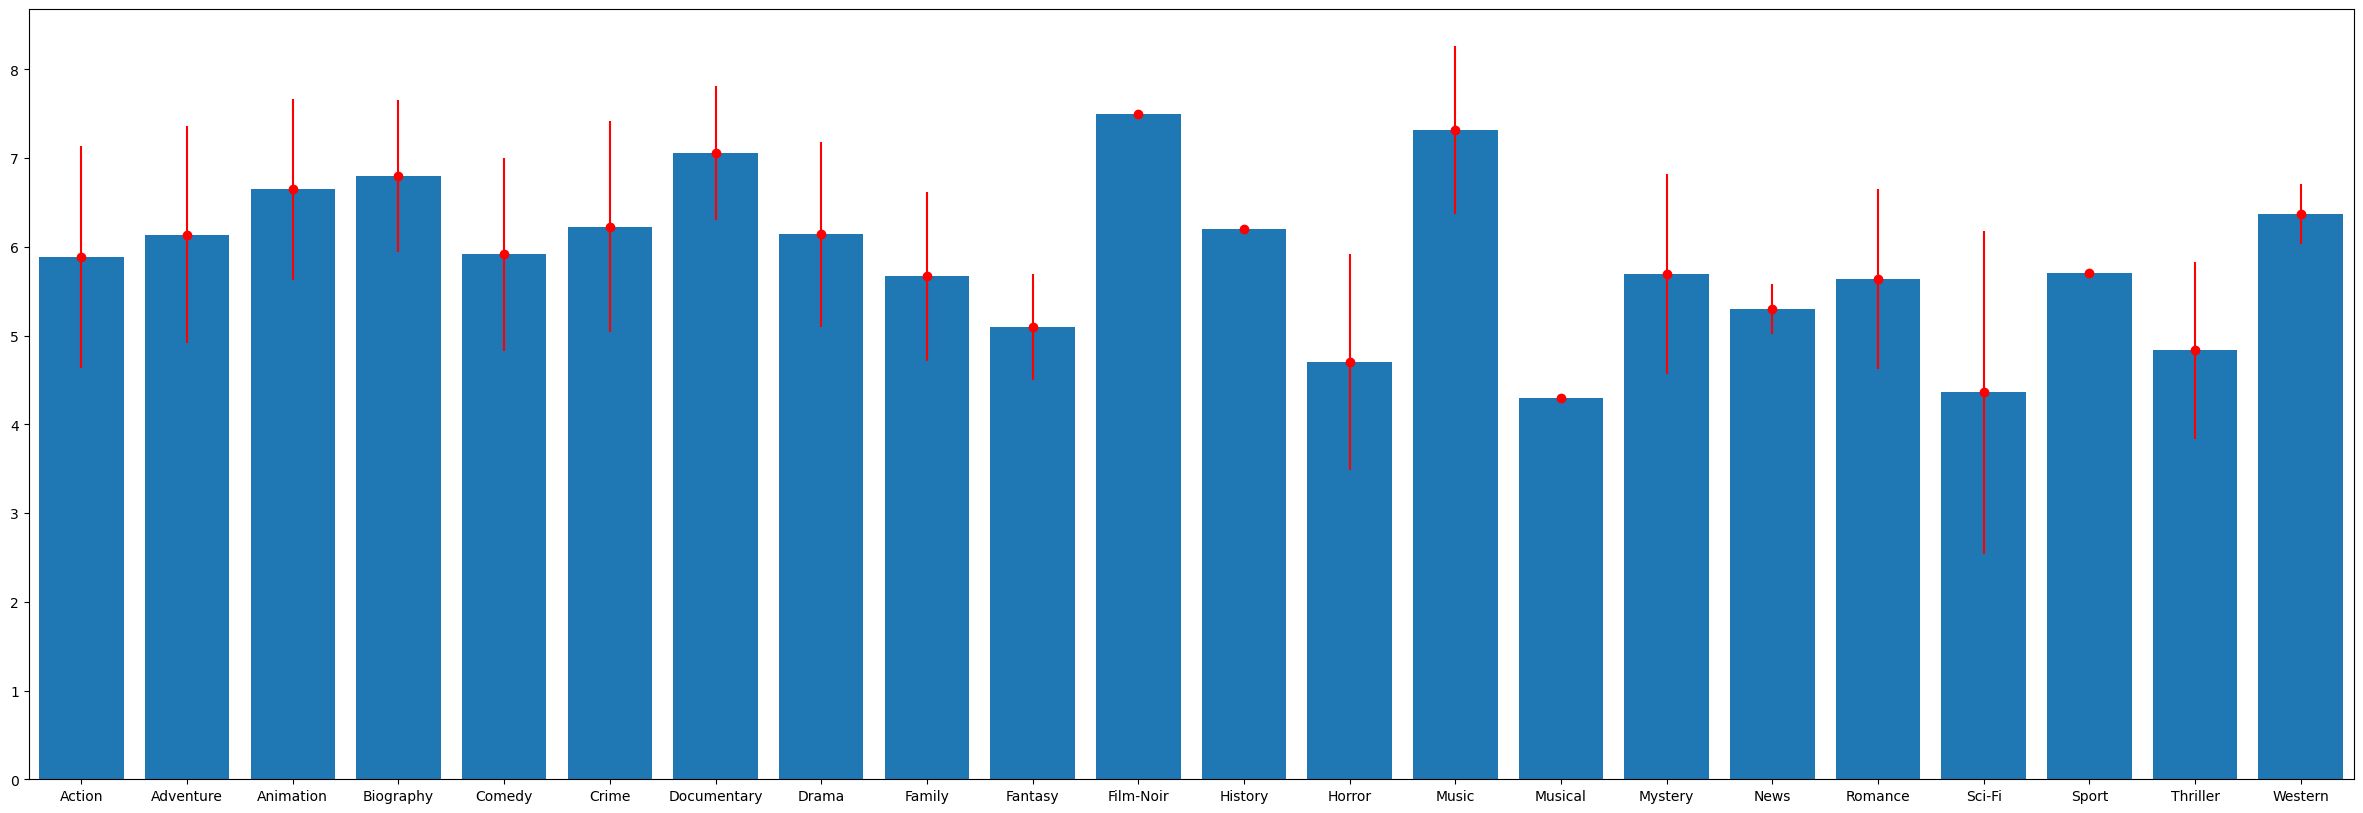

In [55]:

def plot_genre_v_rating(df):
    grouped_df = df.groupby('genre')

    labels = grouped_df.groups.keys()
    means = grouped_df['rating'].mean().tolist()
    stds = grouped_df['rating'].std().tolist()

    plt.figure(figsize=(30, 10))
    plt.bar(x=labels, height=means)
    plt.errorbar(range(len(labels)), means, yerr=stds, fmt="or")
    plt.xlim(-0.5,len(labels)-.5)

    plt.show()

plot_genre_v_rating(df)
plot_genre_v_rating(df.where(df['is_tv'] == True))
plot_genre_v_rating(df.where(df['is_tv'] == False))